In [2]:
# %% [markdown]
# # **RSNA Mammographic Image Classification: Binary (B vs C)**
#
# This notebook implements a deep learning pipeline to classify mammograms into
# breast density categories B (scattered fibroglandular densities) and C
# (heterogeneously dense), using the RSNA Breast Cancer Screening Mammography dataset
# and a pre-trained DeiT (Data-efficient Image Transformer) model.

# %% [markdown]
# ## 1. Setup and Imports

# %%
# Ensure necessary libraries are installed (run this cell if needed)
# !pip install torch torchvision torchaudio timm pandas scikit-learn matplotlib seaborn albumentations tqdm opencv-python torchsummary

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import time
import random
import cv2  # OpenCV for image loading

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms # Keep for potential future use, though Albumentations is primary
import timm # PyTorch Image Models
from torchsummary import summary
import torch.nn.functional as F # For softmax

# Albumentations imports for data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Progress bar
from tqdm import tqdm

print(f"PyTorch Version: {torch.__version__}")
print(f"Timm Version: {timm.__version__}")
print(f"Albumentations Version: {A.__version__}")
print(f"OpenCV Version: {cv2.__version__}")
print(f"Pandas Version: {pd.__version__}")

PyTorch Version: 2.5.1+cu121
Timm Version: 1.0.12
Albumentations Version: 1.4.20
OpenCV Version: 4.10.0
Pandas Version: 2.2.3


In [3]:
# %% [markdown]
# ## 2. Configuration and Paths

# %%
# --- Configuration ---
DATA_PATH = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
IMG_DIR = '/kaggle/input/rsna-breast-cancer-512-pngs' # Directory containing 512x512 PNG images
OUTPUT_DIR = '/kaggle/working/' # Directory to save outputs (like CSVs, model weights)

# Model & Training Hyperparameters
MODEL_NAME = 'deit_base_patch16_224'
IMG_SIZE = 224 # Input size for the model
NUM_CLASSES = 2 # Binary classification: B vs C
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 50 # Max epochs (early stopping will likely trigger sooner)
EARLY_STOPPING_PATIENCE = 10 # Patience for early stopping
NUM_WORKERS = 4 # Number of workers for DataLoader
RANDOM_STATE = 42 # For reproducible splits

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

Using device: cuda
Number of GPUs available: 2


Successfully loaded dataset.
Initial dataset shape: (54706, 14)

First 5 rows:
   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True  

Dataset

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

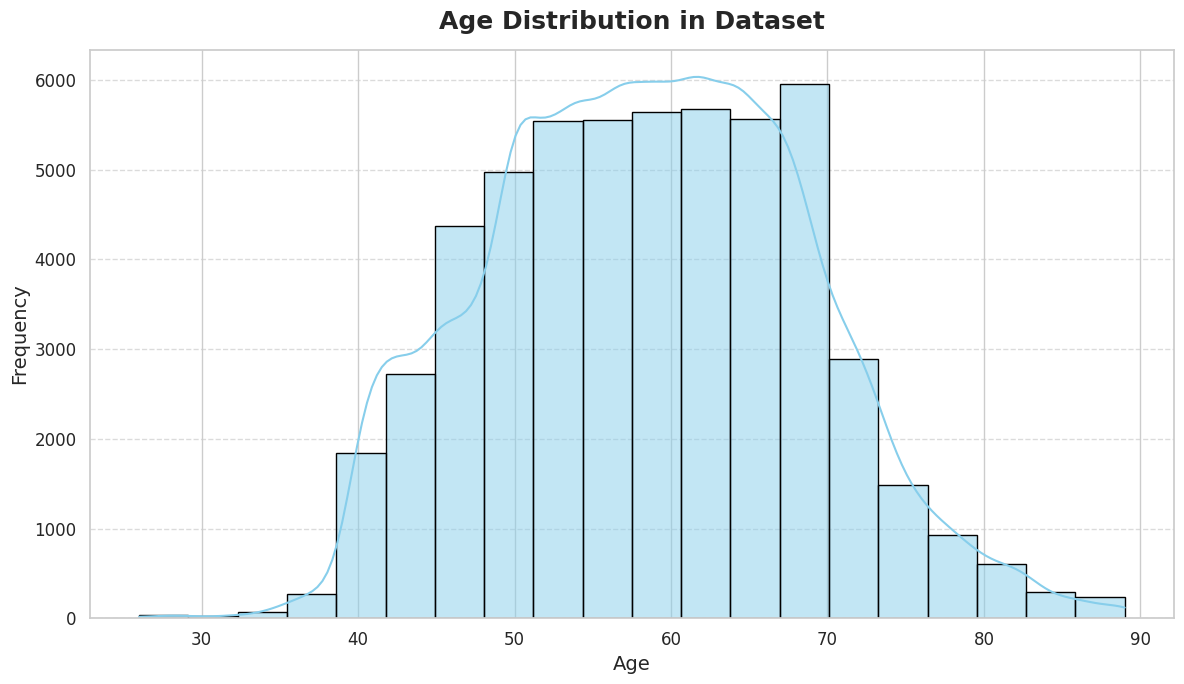

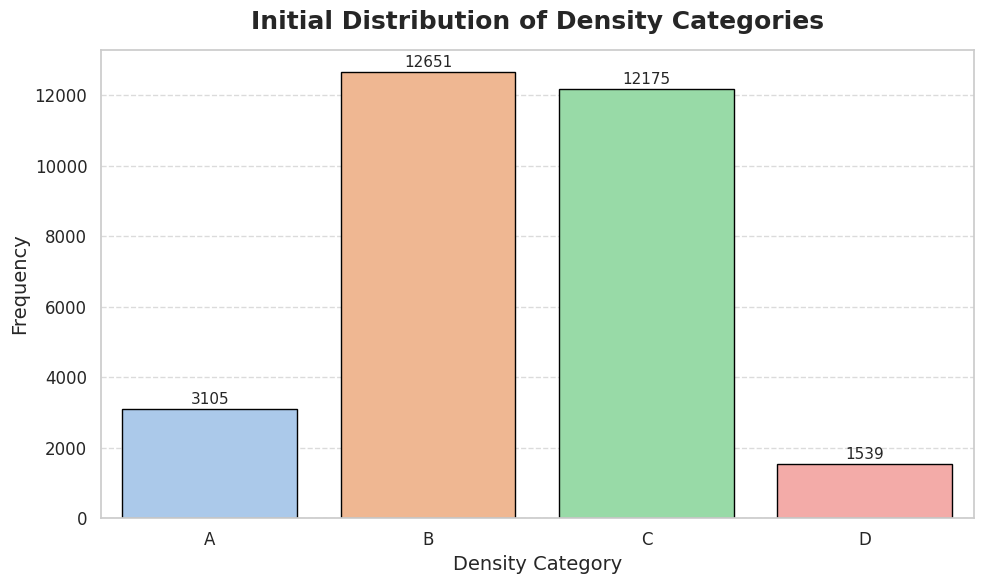

In [4]:
# %% [markdown]
# ## 3. Load and Explore Initial Data

# %%
# Read the CSV file into a DataFrame
try:
    df_rsna = pd.read_csv(DATA_PATH)
    print("Successfully loaded dataset.")
    print(f"Initial dataset shape: {df_rsna.shape}")
except FileNotFoundError:
    print(f"Error: CSV file not found at {DATA_PATH}")
    # Exit or handle error appropriately in a real script
    # For notebook execution, we might just print the error and continue cautiously
    df_rsna = pd.DataFrame() # Create empty df to avoid later errors

if not df_rsna.empty:
    print("\nFirst 5 rows:")
    print(df_rsna.head())

    print("\nDataset Info:")
    df_rsna.info()

    # Checking missing values
    print("\nMissing Values per column:")
    print(df_rsna.isnull().sum())

    # Summary statistics
    print("\nSummary Statistics:")
    print(df_rsna.describe(include='all'))

# %% [markdown]
# ### Initial Visualizations (Age and Density Distribution)

# %%
if not df_rsna.empty and 'age' in df_rsna.columns:
    # Set a high-quality style for the plot
    sns.set(style="whitegrid")

    # Plotting the distribution of 'age'
    plt.figure(figsize=(12, 7))
    sns.histplot(df_rsna['age'].dropna(), bins=20, kde=True, color='skyblue', edgecolor='black')
    plt.title('Age Distribution in Dataset', fontsize=18, fontweight='bold', pad=15)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Age distribution plot (data empty or 'age' column missing).")

if not df_rsna.empty and 'density' in df_rsna.columns:
    # Plotting the distribution of 'density'
    plt.figure(figsize=(10, 6))
    density_counts = df_rsna['density'].value_counts().sort_index() # Sort A, B, C, D
    sns.barplot(x=density_counts.index, y=density_counts.values, palette='pastel', edgecolor='black')
    plt.title('Initial Distribution of Density Categories', fontsize=18, fontweight='bold', pad=15)
    plt.xlabel('Density Category', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Add counts on bars
    for index, value in enumerate(density_counts.values):
        plt.text(index, value + 50, str(value), ha='center', va='bottom', fontsize=11)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Density distribution plot (data empty or 'density' column missing).")


Rows before any preprocessing: 54706
Rows after dropping missing density: 29470
Number of rows with implants (implant == 1): 1460
Rows after removing implants: 28010

Filtering for density categories 'B' and 'C'...
Rows after filtering for B and C: 23513

Density categories mapped to binary labels:
density  density_encoded
B        0                  12194
C        1                  11319
Name: count, dtype: int64

First 5 rows of the final preprocessed binary dataset:
    site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
12        1       10038  1967300488          L  MLO  60.0       0       0   
13        1       10038  2142944869          L   CC  60.0       0       0   
14        1       10038   850559196          R  MLO  60.0       0       0   
15        1       10038  1350492010          R   CC  60.0       0       0   
16        1       10042   102733848          L   CC  51.0       0       0   

    invasive  BIRADS  implant density  machine_id  difficult_n

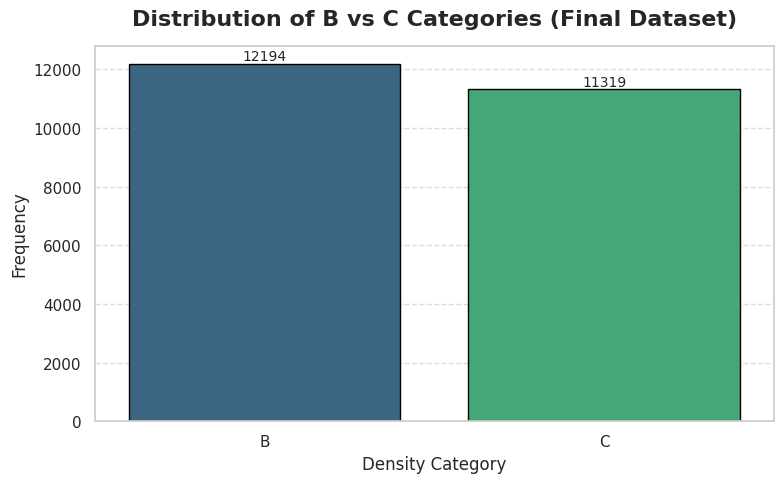

In [5]:
# %% [markdown]
# ## 4. Preprocessing and Filtering for Binary Classification (B vs C)

# %%
if not df_rsna.empty:
    print(f"Rows before any preprocessing: {len(df_rsna)}")

    # Step 1: Drop rows with missing target variable ('density')
    df_processed = df_rsna.dropna(subset=['density']).copy() # Use .copy() to avoid SettingWithCopyWarning
    print(f"Rows after dropping missing density: {len(df_processed)}")

    # Step 2: Remove rows with implants
    implant_count = df_processed[df_processed['implant'] == 1].shape[0]
    print(f"Number of rows with implants (implant == 1): {implant_count}")
    df_processed = df_processed[df_processed['implant'] == 0].copy()
    print(f"Rows after removing implants: {len(df_processed)}")

    # --- Key Step: Filter for Binary Classification (B vs C) ---
    print(f"\nFiltering for density categories 'B' and 'C'...")
    df_binary = df_processed[df_processed['density'].isin(['B', 'C'])].copy()
    print(f"Rows after filtering for B and C: {len(df_binary)}")

    if df_binary.empty:
        print("Error: No data remaining after filtering for densities 'B' and 'C'. Cannot proceed.")
        # Handle error or exit
    else:
        # Step 3: Encode Density Labels for Binary Classification (B -> 0, C -> 1)
        # We explicitly map B to 0 and C to 1 for clarity
        density_map = {'B': 0, 'C': 1}
        df_binary['density_encoded'] = df_binary['density'].map(density_map)
        print("\nDensity categories mapped to binary labels:")
        print(df_binary[['density', 'density_encoded']].value_counts())

        print("\nFirst 5 rows of the final preprocessed binary dataset:")
        print(df_binary.head())

        # Save the preprocessed binary dataframe
        output_path = os.path.join(OUTPUT_DIR, 'df_rsna_binary_preprocessed.csv')
        df_binary.to_csv(output_path, index=False)
        print(f"\nPreprocessed binary dataset saved to: {output_path}")

        # Visualize the distribution of the final binary dataset
        plt.figure(figsize=(8, 5))
        binary_counts = df_binary['density'].value_counts()
        sns.barplot(x=binary_counts.index, y=binary_counts.values, palette='viridis', edgecolor='black')
        plt.title('Distribution of B vs C Categories (Final Dataset)', fontsize=16, fontweight='bold', pad=15)
        plt.xlabel('Density Category', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        for index, value in enumerate(binary_counts.values):
             plt.text(index, value + 20, str(value), ha='center', va='bottom', fontsize=10)
        plt.tight_layout()
        plt.show()

else:
    print("Skipping preprocessing as initial dataframe is empty.")
    df_binary = pd.DataFrame() # Ensure df_binary exists even if empty

In [6]:
# %% [markdown]
# ## 5. Dataset Splitting (Train, Validation, Test)

# %%
if not df_binary.empty:
    # Ensure stratification is possible
    if df_binary['patient_id'].nunique() < 2 or df_binary.groupby('patient_id')['density_encoded'].nunique().max() == 0:
         print("Warning: Cannot perform stratified split properly due to insufficient unique patients or density variations per patient.")
         # Fallback to non-stratified or handle differently if necessary
         # For now, proceed but be aware of potential issues.

    # Group by patient_id to ensure unique patients in each set
    # Use the mode of 'density_encoded' for stratification per patient
    patient_data = df_binary.groupby('patient_id')['density_encoded'].agg(lambda x: x.mode()[0]).reset_index()
    print(f"\nTotal unique patients for splitting: {len(patient_data)}")

    # Check if stratification is feasible with the number of patients per class
    print("Patient counts per density class for stratification:")
    print(patient_data['density_encoded'].value_counts())

    # Check if any class has fewer than 2 members (required for stratification)
    min_members = patient_data['density_encoded'].value_counts().min()
    if min_members < 2:
        print(f"Warning: The smallest class ({patient_data['density_encoded'].value_counts().idxmin()}) has only {min_members} patient(s). Stratification might fail or be unreliable.")
        # Consider alternative splitting strategies if this occurs

    # Split patients into 80% training, 10% validation, 10% test
    try:
        # First, split into 80% training and 20% temporary (for val/test)
        train_patients, temp_patients = train_test_split(
            patient_data,
            test_size=0.2,
            stratify=patient_data['density_encoded'],
            random_state=RANDOM_STATE
        )

        # Split the temporary set into 50% validation and 50% test (10% each of original)
        val_patients, test_patients = train_test_split(
            temp_patients,
            test_size=0.5,
            stratify=temp_patients['density_encoded'],
            random_state=RANDOM_STATE
        )

        # Map patient splits back to the main DataFrame
        train_df = df_binary[df_binary['patient_id'].isin(train_patients['patient_id'])].reset_index(drop=True)
        val_df = df_binary[df_binary['patient_id'].isin(val_patients['patient_id'])].reset_index(drop=True)
        test_df = df_binary[df_binary['patient_id'].isin(test_patients['patient_id'])].reset_index(drop=True)

        # Display sizes and save splits
        print("\nDataset Split Sizes (Number of Images):")
        print(f"Training set size: {len(train_df)}")
        print(f"Validation set size: {len(val_df)}")
        print(f"Test set size: {len(test_df)}")

        # Save the split dataframes
        train_df.to_csv(os.path.join(OUTPUT_DIR, 'train_binary_df.csv'), index=False)
        val_df.to_csv(os.path.join(OUTPUT_DIR, 'val_binary_df.csv'), index=False)
        test_df.to_csv(os.path.join(OUTPUT_DIR, 'test_binary_df.csv'), index=False)
        print("\nTrain, validation, and test CSV files saved successfully.")

        # Verify category distribution in each split
        print("\nCategory distribution in each set (0=B, 1=C):")
        print("Training set:\n", train_df['density_encoded'].value_counts(normalize=True))
        print("\nValidation set:\n", val_df['density_encoded'].value_counts(normalize=True))
        print("\nTest set:\n", test_df['density_encoded'].value_counts(normalize=True))

    except ValueError as e:
        print(f"\nError during stratified split: {e}")
        print("This might happen if a class has too few samples for the split ratios.")
        # Set DFs to empty to prevent downstream errors
        train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

else:
    print("Skipping dataset splitting as the binary dataframe is empty.")
    train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()


Total unique patients for splitting: 4796
Patient counts per density class for stratification:
density_encoded
0    2460
1    2336
Name: count, dtype: int64

Dataset Split Sizes (Number of Images):
Training set size: 18877
Validation set size: 2315
Test set size: 2321

Train, validation, and test CSV files saved successfully.

Category distribution in each set (0=B, 1=C):
Training set:
 density_encoded
0    0.519574
1    0.480426
Name: proportion, dtype: float64

Validation set:
 density_encoded
0    0.511447
1    0.488553
Name: proportion, dtype: float64

Test set:
 density_encoded
0    0.51788
1    0.48212
Name: proportion, dtype: float64


In [7]:
# %% [markdown]
# ## 6. PyTorch Dataset and DataLoaders

# %%
class BreastDensityBinaryDataset(Dataset):
    """
    PyTorch Dataset for loading breast density images (B vs C) and labels.
    Assumes images are named {patient_id}_{image_id}.png
    """
    def __init__(self, csv_file, img_dir, transform=None, file_check=True):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations (e.g., train_df.csv).
            img_dir (string): Directory with all the PNG images.
            transform (callable, optional): Optional Albumentations transform to be applied.
            file_check (bool): If True, checks for the existence of the first few image files.
        """
        try:
            self.data = pd.read_csv(csv_file)
            if 'patient_id' not in self.data.columns or \
               'image_id' not in self.data.columns or \
               'density_encoded' not in self.data.columns:
                raise ValueError("CSV must contain 'patient_id', 'image_id', and 'density_encoded' columns.")
        except FileNotFoundError:
            print(f"Error: CSV file not found at {csv_file}")
            self.data = pd.DataFrame() # Avoid errors later
            return
        except ValueError as e:
             print(f"Error reading CSV {csv_file}: {e}")
             self.data = pd.DataFrame()
             return

        self.img_dir = img_dir
        self.transform = transform

        # Optional: Check if image directory and a few files exist
        if file_check and not self.data.empty:
            if not os.path.isdir(self.img_dir):
                print(f"Warning: Image directory not found at {self.img_dir}")
            else:
                # Check first 5 image paths
                missing_files = 0
                for idx in range(min(5, len(self.data))):
                    img_path = self._get_img_path(idx)
                    if not os.path.exists(img_path):
                        # print(f"Warning: Image file not found: {img_path}")
                        missing_files += 1
                if missing_files > 0:
                     print(f"Warning: {missing_files}/5 checked image files were not found in {self.img_dir}.")


    def _get_img_path(self, idx):
        """Helper function to construct the image path."""
        patient_id = self.data.iloc[idx]['patient_id']
        image_id = self.data.iloc[idx]['image_id']
        return os.path.join(self.img_dir, f"{patient_id}_{image_id}.png")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get image path and label
        img_path = self._get_img_path(idx)
        # Ensure label is integer type
        label = int(self.data.iloc[idx]['density_encoded'])

        try:
            # Load image using OpenCV - loads as BGR by default
            # Mammograms are typically grayscale, load as such directly
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                raise IOError(f"Could not read image: {img_path}")

            # Convert grayscale to 3-channel RGB for compatibility with pre-trained models
            # Many pre-trained models expect 3 input channels.
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder tensor or handle appropriately
            # For simplicity, we might return None or raise error further up
            # Here, let's create a dummy tensor of the expected size
            image = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8) # Placeholder
            label = -1 # Indicate an error

        # Apply Albumentations transformations if specified
        if self.transform:
            try:
                augmented = self.transform(image=image)
                image = augmented['image']
            except Exception as e:
                print(f"Error applying transforms to image {img_path}: {e}")
                # Fallback: Apply basic resize/normalize/tensor conversion if augmentation fails
                basic_transform = A.Compose([
                    A.Resize(IMG_SIZE, IMG_SIZE),
                    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), # Simple normalization
                    ToTensorV2()
                ])
                image = basic_transform(image=image)['image']


        # Return image tensor and label
        # Label needs to be LongTensor for CrossEntropyLoss
        return image, torch.tensor(label, dtype=torch.long)

In [8]:
# %% [markdown]
# ## 7. Data Augmentation and Transformations

# %%
# Define Albumentations transformations

# Normalization: Use ImageNet stats as a starting point, consider calculating dataset-specific stats later
NORM_MEAN = (0.485, 0.456, 0.406)
NORM_STD = (0.229, 0.224, 0.225)

# Training transformations: includes augmentation
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5), # Vertical flips might be less common/useful for mammograms
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.7, border_mode=cv2.BORDER_CONSTANT),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    # A.GaussNoise(var_limit=(10.0, 50.0), p=0.2), # Add noise
    # A.GaussianBlur(blur_limit=(3, 7), p=0.1), # Blurring
    A.CoarseDropout(max_holes=8, max_height=IMG_SIZE//10, max_width=IMG_SIZE//10, min_holes=1, fill_value=0, p=0.3), # Cutout-like augmentation
    A.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ToTensorV2() # Converts image to PyTorch tensor (C, H, W) and scales to [0, 1] if not already done by Normalize
])

# Validation/Test transformations: only resize and normalize
val_test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ToTensorV2()
])


Datasets and DataLoaders created successfully.
Train batches: 589, Val batches: 73, Test batches: 73

Displaying sample augmented images from training loader:


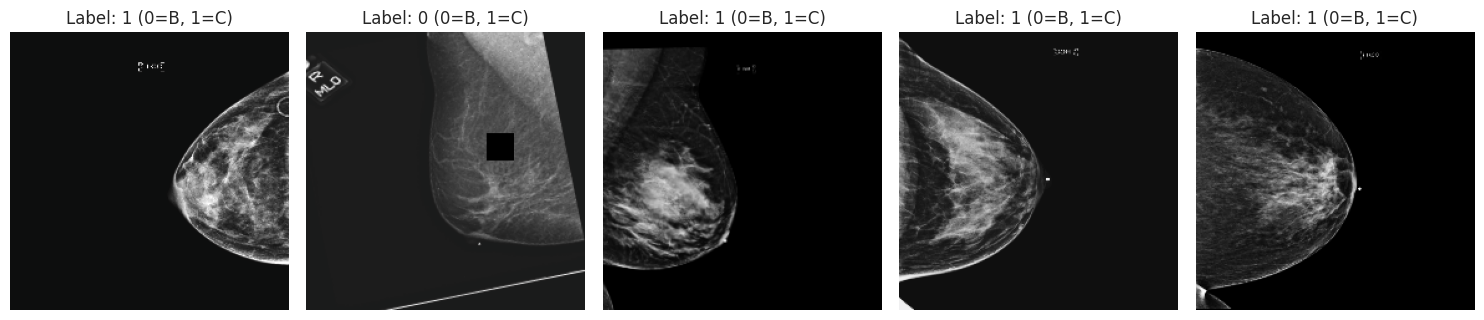

In [9]:
# %% [markdown]
# ## 8. Create Datasets and DataLoaders

# %%
# Paths to the split CSV files
train_csv = os.path.join(OUTPUT_DIR, 'train_binary_df.csv')
val_csv = os.path.join(OUTPUT_DIR, 'val_binary_df.csv')
test_csv = os.path.join(OUTPUT_DIR, 'test_binary_df.csv')

# Check if CSV files exist before creating datasets
if os.path.exists(train_csv) and os.path.exists(val_csv) and os.path.exists(test_csv):
    # Create dataset instances
    train_dataset = BreastDensityBinaryDataset(csv_file=train_csv, img_dir=IMG_DIR, transform=train_transform)
    val_dataset = BreastDensityBinaryDataset(csv_file=val_csv, img_dir=IMG_DIR, transform=val_test_transform)
    test_dataset = BreastDensityBinaryDataset(csv_file=test_csv, img_dir=IMG_DIR, transform=val_test_transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    print("\nDatasets and DataLoaders created successfully.")
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

    # Optional: Display sample images from the train_loader to verify augmentations
    def display_augmented_images(dataloader, num_images=5):
        if not hasattr(dataloader.dataset, 'data') or dataloader.dataset.data.empty:
             print("Cannot display images, dataset is empty.")
             return

        plt.figure(figsize=(15, 5))
        images, labels = next(iter(dataloader)) # Get one batch
        images = images.cpu().numpy() # Move to CPU and convert to numpy

        for i in range(min(num_images, len(images))):
            ax = plt.subplot(1, num_images, i + 1)
            img = images[i]

            # Unnormalize (approximate) for display if Normalize was used
            mean = np.array(NORM_MEAN)
            std = np.array(NORM_STD)
            img = std * img.transpose(1, 2, 0) + mean # Transpose C,H,W -> H,W,C
            img = np.clip(img, 0, 1) # Clip values to [0, 1]

            plt.imshow(img) # Display the RGB image
            plt.title(f"Label: {labels[i].item()} (0=B, 1=C)")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    print("\nDisplaying sample augmented images from training loader:")
    display_augmented_images(train_loader)

else:
    print("\nError: One or more split CSV files not found. Cannot create Datasets/DataLoaders.")
    # Set loaders to None to prevent errors later
    train_loader, val_loader, test_loader = None, None, None


In [10]:
# %% [markdown]
# ## 9. Model Definition (DeiT)

# %%
# Load the pre-trained DeiT model
try:
    model = timm.create_model(MODEL_NAME, pretrained=True)

    # Adjust the final classification layer (head) for NUM_CLASSES (2)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, NUM_CLASSES)
    print(f"Loaded pre-trained model: {MODEL_NAME}")
    print(f"Replaced final layer for {NUM_CLASSES} classes.")

    # Move model to the appropriate device (GPU or CPU)
    model = model.to(DEVICE)

    # Enable multi-GPU training if available
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs via DataParallel.")
        model = nn.DataParallel(model)

    # --- Model Summary ---
    # Calculate total and trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nTotal Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

    # Calculate model size in MB
    param_size = 4 # bytes per parameter (float32)
    model_size_mb = total_params * param_size / (1024 ** 2)
    print(f"Estimated Model Size: {model_size_mb:.2f} MB")

    # Optional: Print detailed model summary using torchsummary (requires input size)
    # print("\nModel Summary (using torchsummary):")
    # summary(model, input_size=(3, IMG_SIZE, IMG_SIZE)) # Input: (channels, height, width)

except Exception as e:
    print(f"Error creating model '{MODEL_NAME}': {e}")
    model = None # Set model to None to prevent errors

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loaded pre-trained model: deit_base_patch16_224
Replaced final layer for 2 classes.
Using 2 GPUs via DataParallel.

Total Parameters: 85,800,194
Trainable Parameters: 85,800,194
Estimated Model Size: 327.30 MB


In [11]:
# %% [markdown]
# ## 10. Training Setup (Loss, Optimizer, Scheduler)

# %%
if model is not None and train_loader is not None:
    # Loss Function: CrossEntropyLoss is suitable for multi-class (and binary) classification
    criterion = nn.CrossEntropyLoss()

    # Optimizer: AdamW is often preferred for transformers
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Learning Rate Scheduler: Reduce LR on plateau of validation loss
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    print("Loss function, optimizer, and scheduler defined.")
else:
    print("Skipping training setup as model or dataloaders are not available.")

Loss function, optimizer, and scheduler defined.


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# %% [markdown]
# ## 11. Training Loop

# %%
if model is not None and train_loader is not None and val_loader is not None:
    # Training tracking variables
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_path = os.path.join(OUTPUT_DIR, f'best_{MODEL_NAME}_binary_BC.pth')
    epochs_no_improve = 0 # Counter for early stopping

    total_start_time = time.time()

    print("\n--- Starting Training ---")

    for epoch in range(EPOCHS):
        epoch_start_time = time.time()

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
        for images, labels in train_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_bar.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)
        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(DEVICE), labels.to(DEVICE)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                val_bar.set_postfix(loss=loss.item())

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # --- Epoch Summary & Best Model Check ---
        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{EPOCHS} | Duration: {epoch_duration:.2f}s")
        print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.4f}")

        # Adjust LR based on validation loss
        scheduler.step(epoch_val_loss)

        # Check for improvement and save best model
        if epoch_val_acc > best_val_accuracy:
            print(f"  Validation accuracy improved ({best_val_accuracy:.4f} -> {epoch_val_acc:.4f}). Saving model...")
            best_val_accuracy = epoch_val_acc
            # Save the model state dict (recommended)
            # If using DataParallel, save module's state_dict
            if isinstance(model, nn.DataParallel):
                 torch.save(model.module.state_dict(), best_model_path)
            else:
                 torch.save(model.state_dict(), best_model_path)
            epochs_no_improve = 0 # Reset counter
        else:
            epochs_no_improve += 1
            print(f"  Validation accuracy did not improve. ({epochs_no_improve}/{EARLY_STOPPING_PATIENCE})")

        # Early stopping
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs.")
            break

    total_training_time = time.time() - total_start_time
    print(f"\n--- Training Finished ---")
    print(f"Total Training Time: {total_training_time // 60:.0f}m {total_training_time % 60:.2f}s")
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
    print(f"Best model saved to: {best_model_path}")

    # --- Plot Training History ---
    epochs_ran = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_ran, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs_ran, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_ran, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs_ran, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("Skipping training loop as model or dataloaders are not available.")



--- Starting Training ---


Epoch 1/50 | Duration: 415.56s
  Train Loss: 0.3623 | Train Acc: 0.8375
  Val Loss:   0.3886 | Val Acc:   0.8138
  Validation accuracy improved (0.0000 -> 0.8138). Saving model...


Epoch 2/50 | Duration: 434.08s
  Train Loss: 0.3312 | Train Acc: 0.8532
  Val Loss:   0.3612 | Val Acc:   0.8272
  Validation accuracy improved (0.8138 -> 0.8272). Saving model...


Epoch 3/50 | Duration: 434.07s
  Train Loss: 0.3129 | Train Acc: 0.8625
  Val Loss:   0.3467 | Val Acc:   0.8471
  Validation accuracy improved (0.8272 -> 0.8471). Saving model...


Epoch 4/50 | Duration: 434.78s
  Train Loss: 0.3074 | Train Acc: 0.8632
  Val Loss:   0.3467 | Val Acc:   0.8475
  Validation accuracy improved (0.8471 -> 0.8475). Saving model...


Epoch 5/50 | Duration: 434.68s
  Train Loss: 0.2966 | Train Acc: 0.8682
  Val Loss:   0.3678 | Val Acc:   0.8402
  Validation accuracy did not improve. (1/10)


Epoch 6/50 [Train]:  40%|████      | 237/589 [02:48<04:09,  1.41it/s, loss=0.241]

In [ ]:
# %% [markdown]
# ## 12. Evaluation on Test Set

# %%
if model is not None and test_loader is not None and os.path.exists(best_model_path):
    print("\n--- Evaluating on Test Set ---")

    # Load the best model weights
    # Need to initialize the model structure first
    eval_model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES) # Don't need pretrained weights here

    # Handle DataParallel state dict loading if necessary
    state_dict = torch.load(best_model_path, map_location=DEVICE)
    # If the saved state_dict is from DataParallel (keys start with 'module.'),
    # but we are loading into a non-DataParallel model, remove 'module.' prefix.
    # Conversely, if loading a non-DP state_dict into a DP model, add 'module.'
    # Simplest approach: try loading directly, if it fails, adjust keys.

    try:
        # If the current eval_model is wrapped in DataParallel
        if isinstance(eval_model, nn.DataParallel):
             # Check if state_dict keys start with 'module.'
             if not next(iter(state_dict)).startswith('module.'):
                  # Add 'module.' prefix if needed
                  state_dict = {'module.' + k: v for k, v in state_dict.items()}
             eval_model.load_state_dict(state_dict)
        # If the current eval_model is *not* wrapped in DataParallel
        else:
             # Check if state_dict keys start with 'module.'
             if next(iter(state_dict)).startswith('module.'):
                  # Remove 'module.' prefix if needed
                  state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
             eval_model.load_state_dict(state_dict)

    except RuntimeError as e:
         print(f"State dict loading error: {e}. Attempting key adjustment (removing 'module.').")
         # Common issue: loading DataParallel weights into a non-DataParallel model
         from collections import OrderedDict
         new_state_dict = OrderedDict()
         for k, v in state_dict.items():
             name = k[7:] if k.startswith('module.') else k # remove `module.` prefix
             new_state_dict[name] = v
         try:
             eval_model.load_state_dict(new_state_dict)
         except Exception as inner_e:
             print(f"Failed to load state dict even after adjustment: {inner_e}")
             eval_model = None # Mark as failed

    if eval_model:
        eval_model = eval_model.to(DEVICE)
        # Wrap with DataParallel if multiple GPUs are available for evaluation consistency
        if torch.cuda.device_count() > 1 and not isinstance(eval_model, nn.DataParallel):
             eval_model = nn.DataParallel(eval_model)

        eval_model.eval() # Set model to evaluation mode

        all_preds = []
        all_labels = []
        correct_test = 0
        total_test = 0

        test_bar = tqdm(test_loader, desc="[Test Evaluation]", leave=False)
        with torch.no_grad():
            for images, labels in test_bar:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = eval_model(images)
                _, predicted = torch.max(outputs.data, 1)

                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_accuracy = correct_test / total_test
        print(f"\nTest Accuracy: {test_accuracy:.4f} ({correct_test}/{total_test})")

        # --- Classification Report and Confusion Matrix ---
        target_names = ['Density B (0)', 'Density C (1)'] # Labels for the report/matrix
        print("\nClassification Report (Test Set):")
        print(classification_report(all_labels, all_preds, target_names=target_names))

        print("\nConfusion Matrix (Test Set):")
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

        fig, ax = plt.subplots(figsize=(7, 7))
        disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='horizontal')
        plt.title("Confusion Matrix - Test Set")
        plt.tight_layout()
        plt.show()

else:
    print("Skipping test set evaluation: Model, test loader, or best model file not available.")

In [ ]:
# %% [markdown]
# ## 13. Prediction Visualization (Sample Images)

# %%
if eval_model is not None and test_dataset is not None:
    print("\n--- Visualizing Sample Predictions from Test Set ---")

    def display_predictions(dataset, model, num_images=6):
        model.eval()
        plt.figure(figsize=(15, 8)) # Adjust figure size

        # Get random indices from the dataset
        indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))

        for i, idx in enumerate(indices):
            # Get image and true label
            # Important: Get item directly from dataset to get original label before tensor conversion
            image_tensor, true_label_tensor = dataset[idx]
            true_label = true_label_tensor.item() # Get Python int from tensor

            # Prepare image for model (add batch dim, move to device)
            image_tensor = image_tensor.unsqueeze(0).to(DEVICE)

            # Get prediction and confidence
            with torch.no_grad():
                output = model(image_tensor)
                probabilities = F.softmax(output, dim=1)
                confidence, predicted_label_tensor = torch.max(probabilities, 1)
                predicted_label = predicted_label_tensor.item()
                conf_score = confidence.item()

            # Prepare image for display (move to CPU, remove batch dim, unnormalize)
            img_display = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0) # H, W, C
            mean = np.array(NORM_MEAN)
            std = np.array(NORM_STD)
            img_display = std * img_display + mean
            img_display = np.clip(img_display, 0, 1)

            # Plot
            ax = plt.subplot((num_images + 2) // 3, 3, i + 1) # Arrange in grid
            plt.imshow(img_display)
            plt.axis("off")
            title_color = 'green' if predicted_label == true_label else 'red'
            ax.set_title(f"True: {target_names[true_label]}\nPred: {target_names[predicted_label]}\nConf: {conf_score:.2%}",
                         color=title_color, fontsize=10)

        plt.tight_layout()
        plt.show()

    display_predictions(test_dataset, eval_model, num_images=9)

else:
    print("Skipping prediction visualization: Evaluation model or test dataset not available.")

# %% [markdown]
# --- End of Notebook ---